In [1]:
import numpy as np
import matplotlib.pyplot as plt
from normals import compute_local_PCA
from ply import write_ply, read_ply
from scipy.interpolate import BSpline

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [ ]:
# Import the point clouds 
#path = ''
#points = read_ply(path)

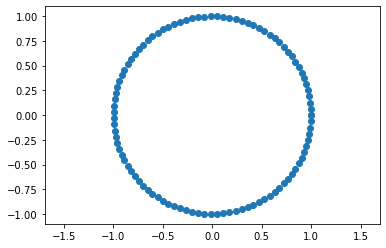

In [62]:
# create a 2D circle
theta = np.linspace(0, 2*np.pi, 100)
r = 1
points = np.array([r*np.cos(theta), r*np.sin(theta)]).T

plt.scatter(points[:, 0], points[:, 1])
plt.axis('equal')
plt.show()

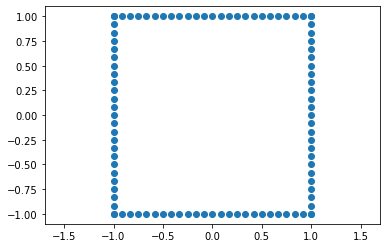

In [55]:
# create a 2D square with 100 pointq
points = []
points.append(np.array([np.linspace(-1, 1, 25), np.ones(25)]).T)
points.append(np.array([np.ones(25), np.linspace(1, -1, 25)]).T)
points.append(np.array([np.linspace(1, -1, 25), -np.ones(25)]).T)
points.append(np.array([-np.ones(25), np.linspace(-1, 1, 25)]).T)
points = np.concatenate(points)
plt.scatter(points[:, 0], points[:, 1])
plt.axis('equal')
plt.show()

(-1.0994713695023444,
 1.0999748271191592,
 -1.0998615404412626,
 1.0998615404412626)

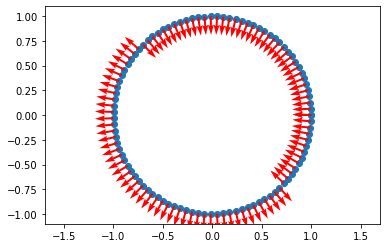

In [44]:
# Import the normals
normals = compute_local_PCA(points, points, d=2, nghbrd_search="knn", k=5)

plt.scatter(points[:, 0], points[:, 1])
plt.quiver(points[:, 0], points[:, 1], normals[1][:, 0, 0], normals[1][:, 1, 0], color='r')
plt.axis('equal')

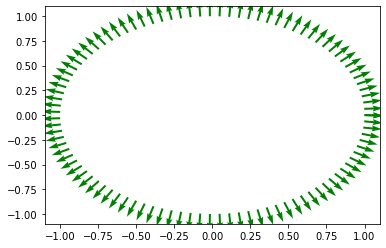

In [45]:
for i in range(len(points)):
    point = points[i]
    if point[0] + point[1] >= 0:
        normals[1][i, :, 0] *= -1
#normals[1][:,:,0] *= -1
plt.quiver(points[:, 0], points[:, 1], normals[1][:, 0, 0], normals[1][:, 1, 0], color='g')

Define octree

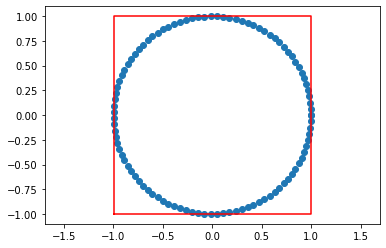

In [46]:
# Compute bounding box
min_x = np.min(points[:, 0])
max_x = np.max(points[:, 0])
min_y = np.min(points[:, 1])
max_y = np.max(points[:, 1])
plt.plot([min_x, max_x, max_x, min_x, min_x], [min_y, min_y, max_y, max_y, min_y], 'r')
plt.scatter(points[:, 0], points[:, 1])
plt.axis('equal')
plt.show()

In [47]:
import pyqtree

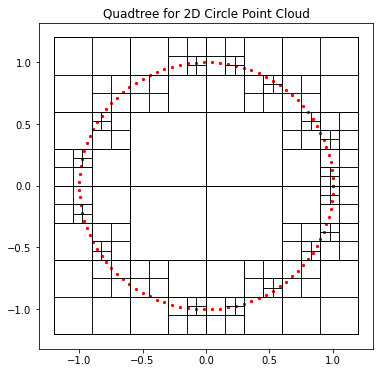

In [ ]:
class QuadtreeNode:
    def __init__(self, x_min, x_max, y_min, y_max, depth=0, max_depth=5, max_points=5):
        self.x_min, self.x_max = x_min, x_max
        self.y_min, self.y_max = y_min, y_max
        self.children = []  # Subdivided regions
        self.points = []  # Points in this region
        self.depth = depth
        self.max_depth = max_depth
        self.max_points = max_points

    def insert(self, point):
        """Insert a point into the quadtree."""
        if self.children:  # If node is already subdivided, pass the point to the correct child
            for child in self.children:
                if child.contains(point):
                    child.insert(point)
                    return

        # Otherwise, store the point in this node
        self.points.append(point)

        # If node exceeds max points and isn't too deep, subdivide
        if len(self.points) > self.max_points and self.depth < self.max_depth:
            self.subdivide()

    def contains(self, point):
        """Check if a point is inside this node's boundaries."""
        x, y = point
        return self.x_min <= x < self.x_max and self.y_min <= y < self.y_max

    def subdivide(self):
        """Split the node into 4 child quadrants."""
        cx, cy = (self.x_min + self.x_max) / 2, (self.y_min + self.y_max) / 2
        self.children = [
            QuadtreeNode(self.x_min, cx, self.y_min, cy, self.depth + 1, self.max_depth, self.max_points),  # Bottom-left
            QuadtreeNode(cx, self.x_max, self.y_min, cy, self.depth + 1, self.max_depth, self.max_points),  # Bottom-right
            QuadtreeNode(self.x_min, cx, cy, self.y_max, self.depth + 1, self.max_depth, self.max_points),  # Top-left
            QuadtreeNode(cx, self.x_max, cy, self.y_max, self.depth + 1, self.max_depth, self.max_points),  # Top-right
        ]
        
        # Reassign points to children
        for p in self.points:
            for child in self.children:
                if child.contains(p):
                    child.insert(p)
                    break
        self.points = []  # Clear points from parent node

    def plot(self):
        """Recursively plot the quadtree structure."""
        plt.plot([self.x_min, self.x_max, self.x_max, self.x_min, self.x_min],
                 [self.y_min, self.y_min, self.y_max, self.y_max, self.y_min], 'k', linewidth=0.7)
        for child in self.children:
            child.plot()

    def generate_knot_vectors(self):
        """Generate uniform knot vectors based on quadtree subdivisions."""
        x_knots = sorted(set([bbox[0] for bbox in self.bbox_list] + [bbox[2] for bbox in self.bbox_list]))
        y_knots = sorted(set([bbox[1] for bbox in self.bbox_list] + [bbox[3] for bbox in self.bbox_list]))

        # Add additional knots for B-Spline boundary conditions
        k = self.spline_degree
        self.knots_x = np.concatenate(([x_knots[0]] * k, x_knots, [x_knots[-1]] * k))
        self.knots_y = np.concatenate(([y_knots[0]] * k, y_knots, [y_knots[-1]] * k))


# Define Quadtree root node
root = QuadtreeNode(-1.2, 1.2, -1.2, 1.2, max_depth=6, max_points=2)

# Insert points into the quadtree
for p in points:
    root.insert(tuple(p))

# Plot Quadtree
plt.figure(figsize=(6, 6))
root.plot()  # Draw quadtree boundaries
plt.scatter(points[:, 0], points[:, 1], s=5, color='red')  # Plot points
plt.title("Quadtree for 2D Circle Point Cloud")
plt.show()


Define the grid 

In [71]:
root = QuadtreeNode(-1.2, 1.2, -1.2, 1.2, max_depth=6, max_points=2)
list_knots = root.extract_center()
print(list_knots)

[[0.0, 0.0]]


In [ ]:
# Define the B-spline basis functions
splines = []
k = 2
knots = np.array([])
n_basis = len(knots) - (k + 1)
for i in range(n_basis):
    # Create B-spline basis function
    coeffs = np.zeros(n_basis)
    coeffs[i] = 1  # Activate one basis function at a time
    spline = BSpline(knots, coeffs, k)
    splines.append(spline)

Solve the linear system